In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/LP/sa_work/AS209/AS209_continuum.fits',
                          'distance':121,
                          'incl' : 34.7,
                          'PA' : 86.2,
                          'offsetx' : 0.39*.003,
                          'offsety' : -1.12*.003,
                          'size': 3.5,
                          'gamma': 0.6
                         }

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


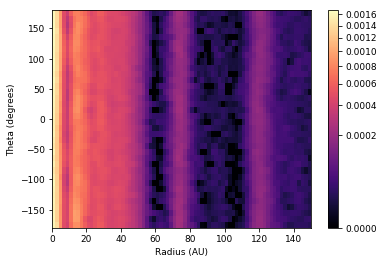

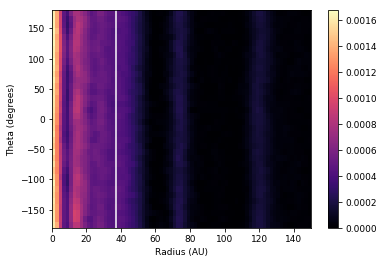

In [3]:


#make some preliminary plots
cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    
radialbins = 1+2*np.arange(75)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0)
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.vlines(37,-180,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


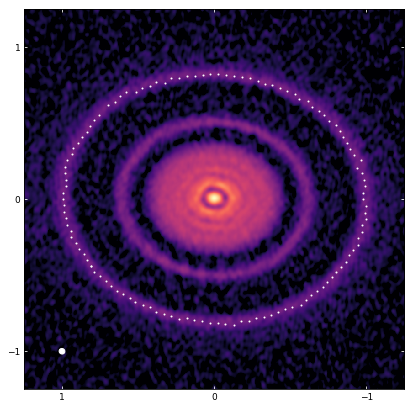

In [4]:
# Extract the ring that's at ~120 AU
xcoords1, ycoords1 = cont.extract_ring(110,130,tbins = -178.5+3*np.arange(120), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.5, 2.5)

In [5]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     1.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 2.121e-04 arcsec, delta_y = 2.069e-03 arcsec
The MLE semi-major axis is r = 0.993 arcsec
The MLE inclination is i = 34.904 degrees
The MLE position angle is PA = 85.535 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.669e+00


In [6]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    #flat priors on x0, y0, r0, logvar
    if not (-4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5):
        return -np.inf
    #gaussian prior on PA and cosi based on Fedele+ 2018
    sig_par = .0122
    sig_cosi = .008
    return -0.5*((par-1.50)/sig_par)**2-0.5*((cosi-0.816)/sig_cosi)**2

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000

In [7]:
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

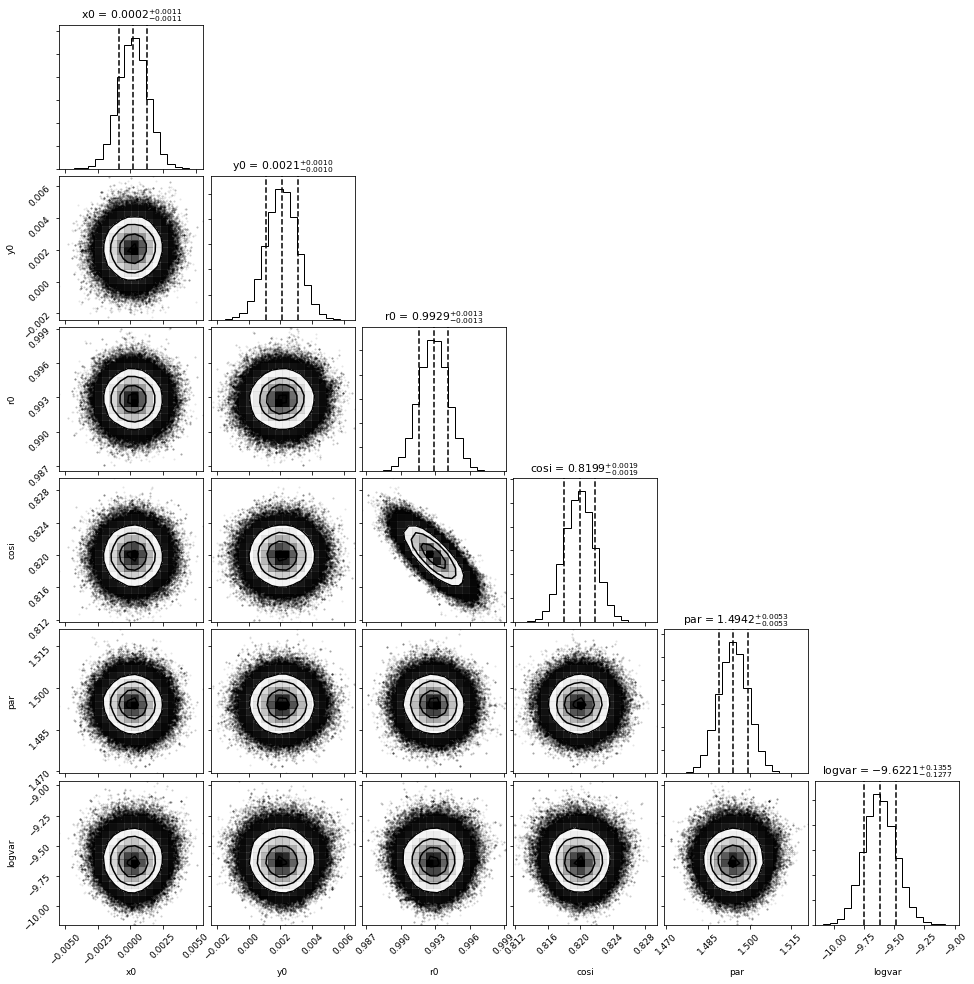

The x offset is delta_x = 1.91e-04 arcsec (+1.1e-03, -1.1e-03)
The y offset is delta_y = 2.09e-03 arcsec (+9.9e-04, -1.0e-03)
The median semi-major axis is r = 0.9929 arcsec (+0.0013, -0.0013) 
or 120.14 AU (+0.12, -0.12)
The incl is i = 34.92 deg (+0.19, -0.19)
The median position angle is PA = 85.61 deg (+0.30, -0.31)
The median log-variance in the pixel offsets from the true ellipse is -9.622e+00


In [8]:
plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


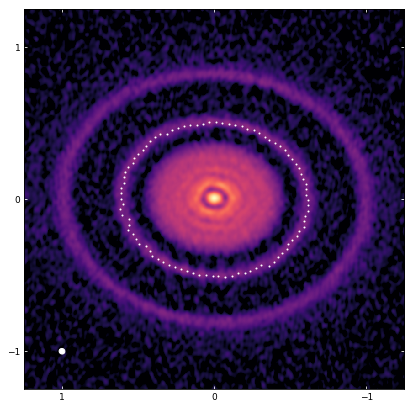

In [9]:
# Extract the ring that's at ~75 AU
xcoords2, ycoords2 = cont.extract_ring(65,85,tbins = -178+4*np.arange(90))

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.5, 2.5)

In [10]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     75/121.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 8.202e-04 arcsec, delta_y = -4.444e-03 arcsec
The MLE semi-major axis is r = 0.613 arcsec
The MLE inclination is i = 34.859 degrees
The MLE position angle is PA = 85.586 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.942e+00


In [11]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

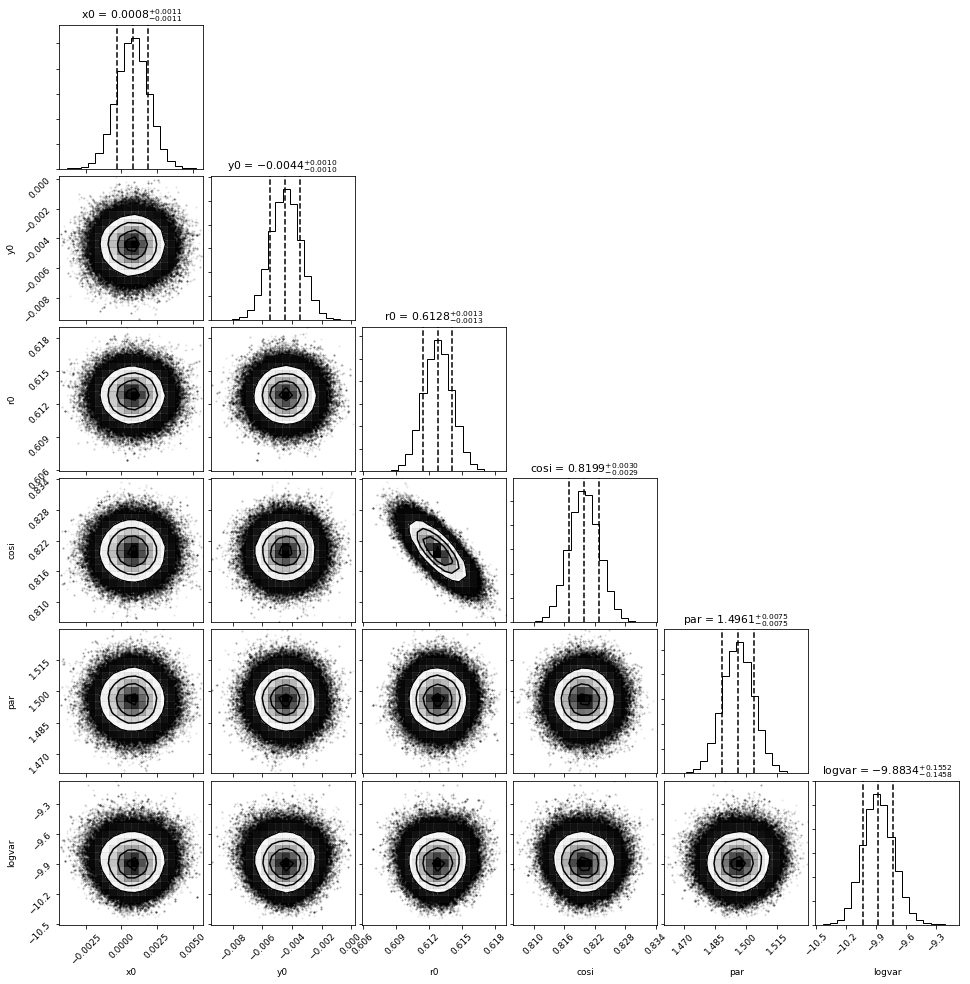

The x offset is delta_x = 7.78e-04 arcsec (+1.1e-03, -1.1e-03)
The y offset is delta_y = -4.44e-03 arcsec (+1.0e-03, -1.0e-03)
The median semi-major axis is r = 0.6128 arcsec (+0.0013, -0.0013) 
or 74.15 AU (+0.12, -0.12)
The incl is i = 34.92 deg (+0.29, -0.30)
The median position angle is PA = 85.72 deg (+0.43, -0.43)
The median log-variance in the pixel offsets from the true ellipse is -9.883e+00


In [12]:
plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


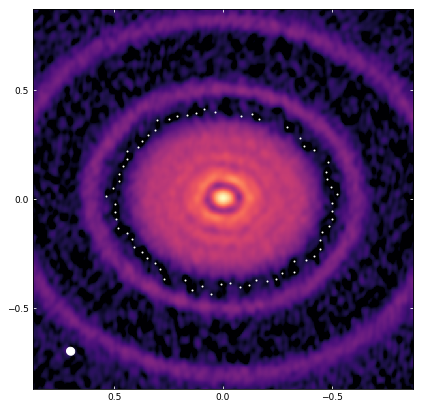

In [13]:
# Extract the gap that's at ~60 AU
xcoords3, ycoords3 = cont.extract_ring(55,65,tbins = -177.5+5*np.arange(72), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords3, ycoords3, 0.5, 1.75)

In [14]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_3 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.5,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -1.861e-03 arcsec, delta_y = -3.667e-03 arcsec
The MLE semi-major axis is r = 0.504 arcsec
The MLE inclination is i = 36.434 degrees
The MLE position angle is PA = 86.534 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.548e+00


In [15]:
sampler3 = run_mcmc(nwalkers, nthreads, nsteps, mle_3, lnprob, xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

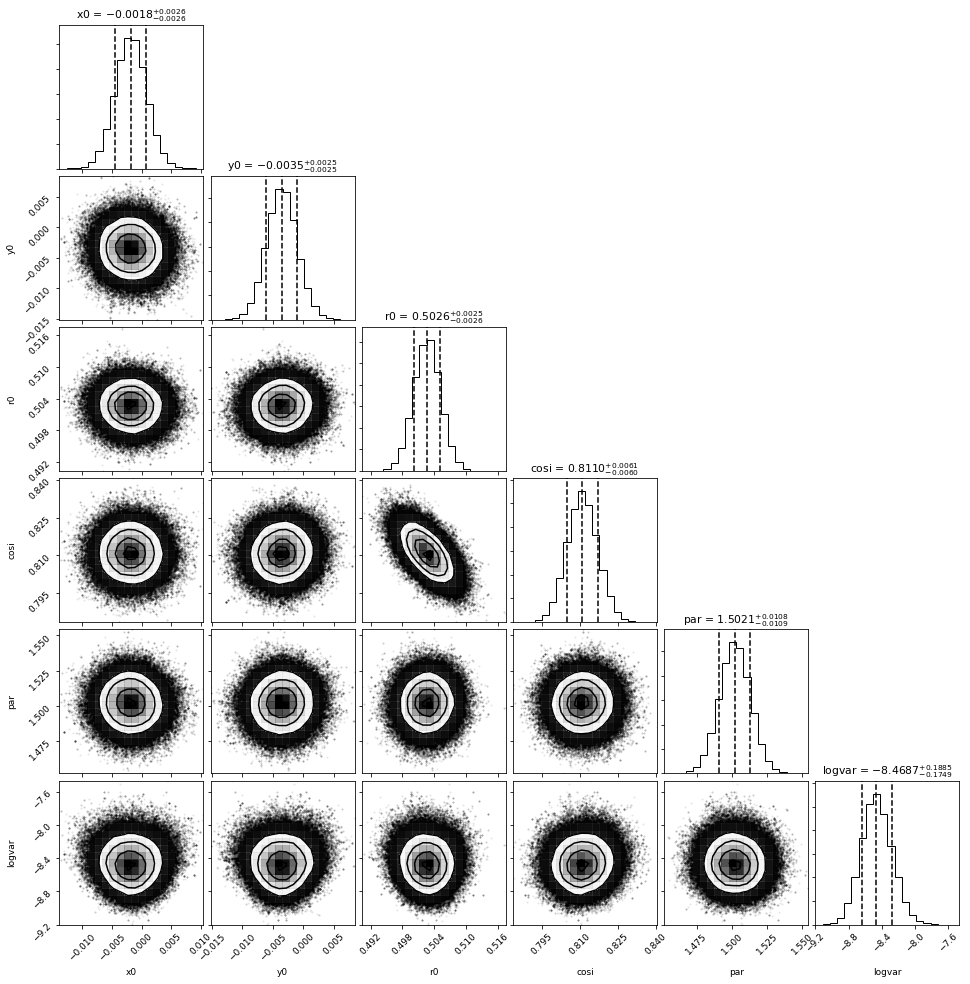

The x offset is delta_x = -1.84e-03 arcsec (+2.6e-03, -2.6e-03)
The y offset is delta_y = -3.53e-03 arcsec (+2.5e-03, -2.5e-03)
The median semi-major axis is r = 0.5026 arcsec (+0.0025, -0.0026) 
or 60.82 AU (+0.30, -0.30)
The incl is i = 35.81 deg (+0.58, -0.60)
The median position angle is PA = 86.06 deg (+0.62, -0.62)
The median log-variance in the pixel offsets from the true ellipse is -8.469e+00


In [16]:
plot_corner(sampler3, 500, 1)
sampler_results(sampler3, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.897e-03 arcsec, delta_y = -2.546e-03 arcsec
The MLE semi-major axis is r = 0.319 arcsec
The MLE inclination is i = 33.806 degrees
The MLE position angle is PA = 83.832 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.580e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


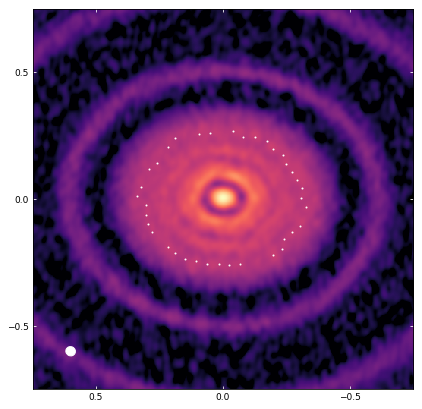

In [17]:
# Extract the ring that's at ~40 AU
xcoords4, ycoords4 = cont.extract_ring(36,44,tbins = -176+8*np.arange(45))

cont.plot_extracted_ring(cont,xcoords4, ycoords4, 0.5, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_4 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     .33,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords4, ycoords4)

In [18]:
sampler4 = run_mcmc(nwalkers, nthreads, nsteps, mle_4, lnprob, xcoords4, ycoords4)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

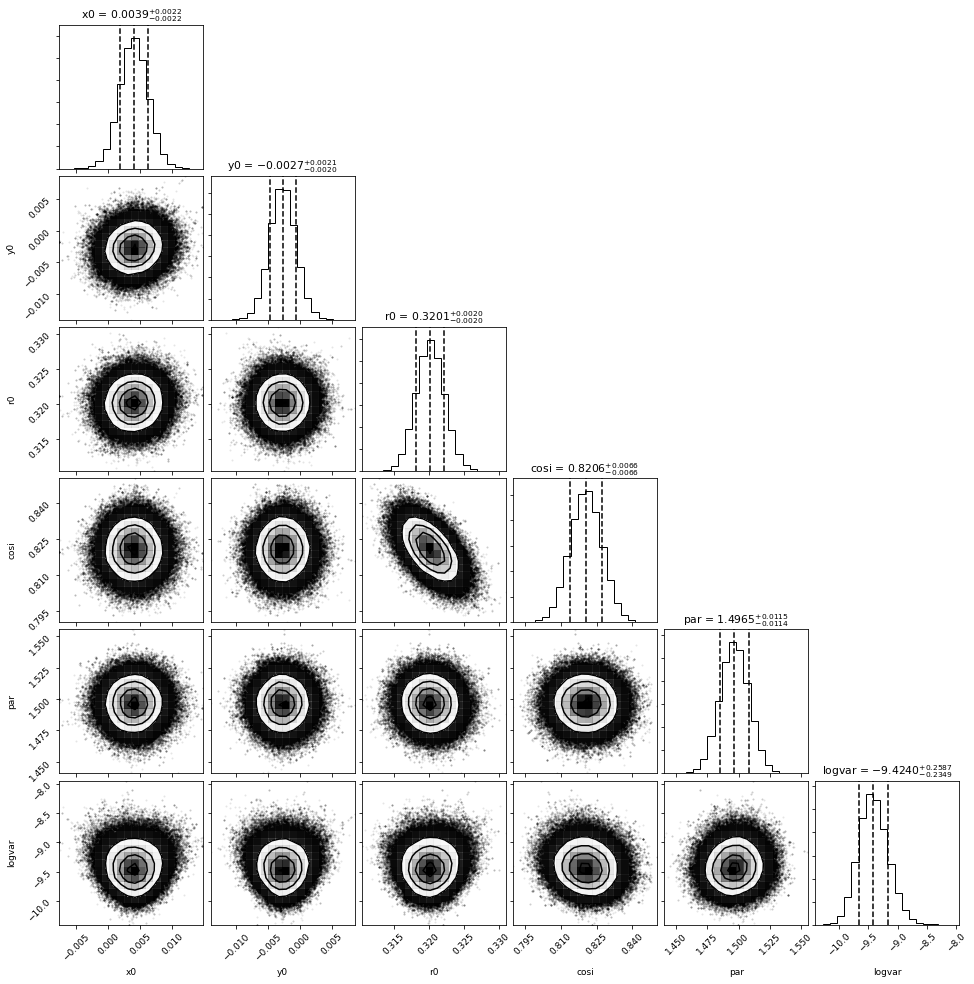

The x offset is delta_x = 3.95e-03 arcsec (+2.2e-03, -2.2e-03)
The y offset is delta_y = -2.69e-03 arcsec (+2.1e-03, -2.0e-03)
The median semi-major axis is r = 0.3201 arcsec (+0.0020, -0.0020) 
or 38.74 AU (+0.25, -0.24)
The incl is i = 34.86 deg (+0.65, -0.67)
The median position angle is PA = 85.74 deg (+0.66, -0.65)
The median log-variance in the pixel offsets from the true ellipse is -9.424e+00


In [19]:
plot_corner(sampler4, 500, 1)
sampler_results(sampler4, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


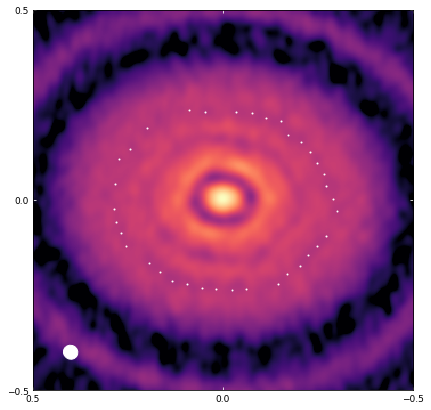

In [20]:
# Extract the gap that's at ~35 AU
xcoords5, ycoords5 = cont.extract_ring(33,37,tbins = -176+8*np.arange(45), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords5, ycoords5, 0.5, 1)

In [21]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_5 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     35/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 4.909e-03 arcsec, delta_y = -2.988e-03 arcsec
The MLE semi-major axis is r = 0.290 arcsec
The MLE inclination is i = 34.936 degrees
The MLE position angle is PA = 82.135 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.030e+01


In [22]:
sampler5 = run_mcmc(nwalkers, nthreads, nsteps, mle_5, lnprob, xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

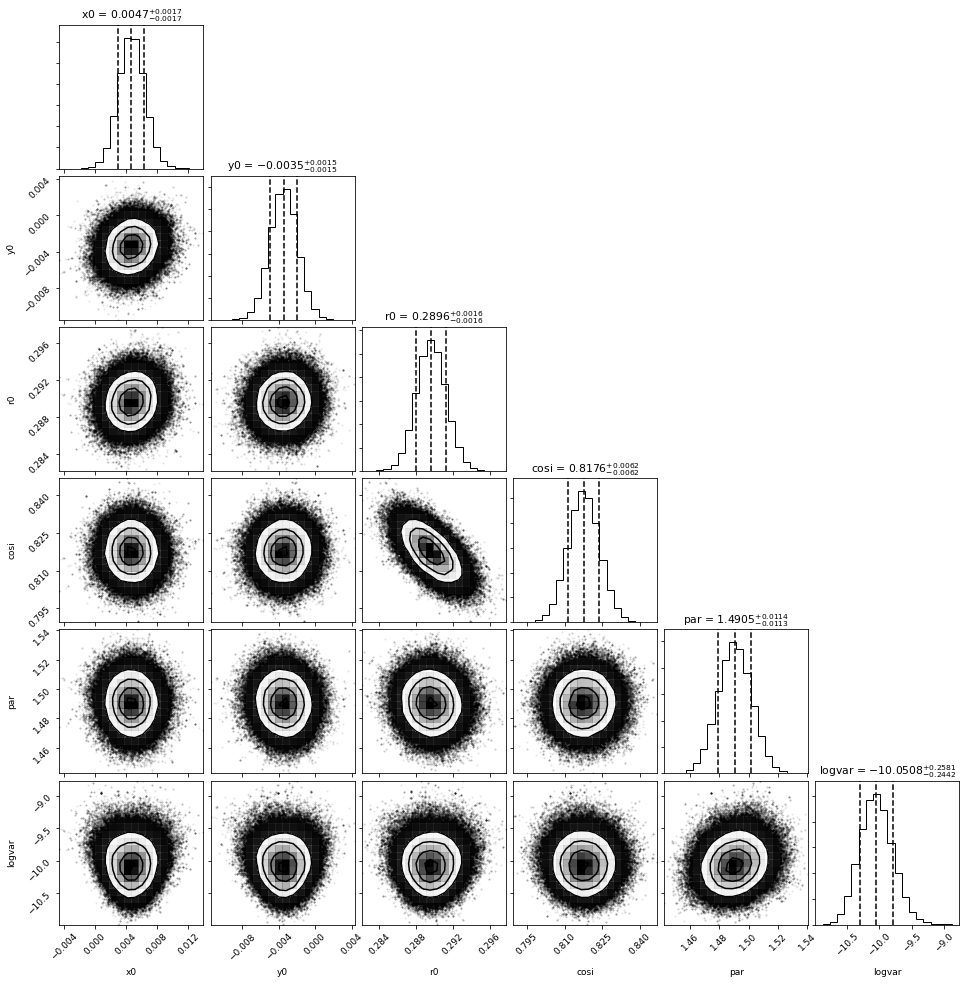

The x offset is delta_x = 4.68e-03 arcsec (+1.7e-03, -1.7e-03)
The y offset is delta_y = -3.45e-03 arcsec (+1.5e-03, -1.5e-03)
The median semi-major axis is r = 0.2896 arcsec (+0.0016, -0.0016) 
or 35.04 AU (+0.18, -0.18)
The incl is i = 35.15 deg (+0.61, -0.62)
The median position angle is PA = 85.40 deg (+0.65, -0.65)
The median log-variance in the pixel offsets from the true ellipse is -1.005e+01


In [23]:
plot_corner(sampler5, 500, 1)
sampler_results(sampler5, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.080e-03 arcsec, delta_y = -4.176e-03 arcsec
The MLE semi-major axis is r = 0.229 arcsec
The MLE inclination is i = 34.163 degrees
The MLE position angle is PA = 88.619 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.496e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


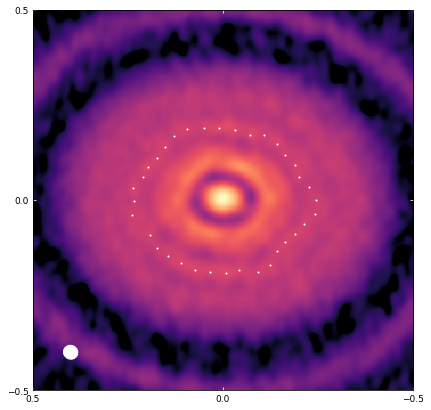

In [24]:
# Extract the gap that's at ~27 AU
xcoords6, ycoords6 = cont.extract_ring(24,30,tbins = -175+10*np.arange(36))

cont.plot_extracted_ring(cont,xcoords6, ycoords6, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_6 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     27/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords6, ycoords6)

In [25]:
sampler6 = run_mcmc(nwalkers, nthreads, nsteps, mle_6, lnprob, xcoords6, ycoords6)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

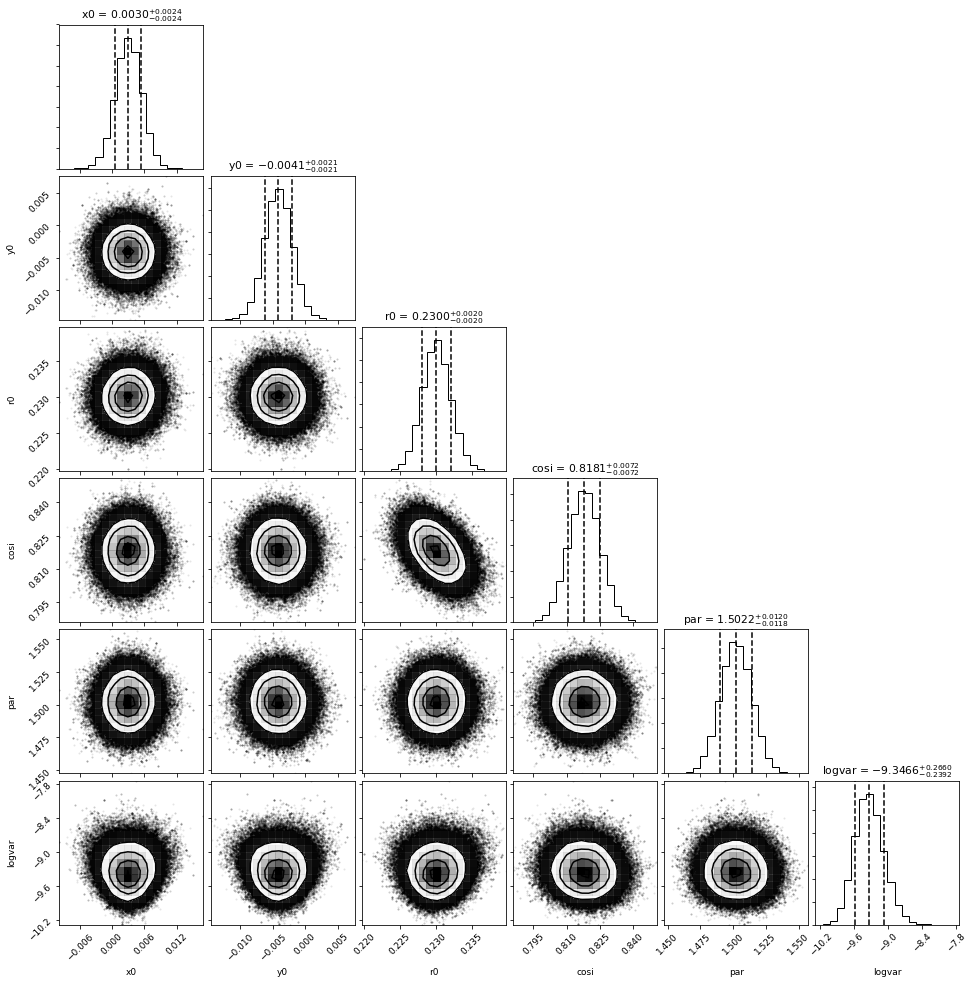

The x offset is delta_x = 3.04e-03 arcsec (+2.4e-03, -2.4e-03)
The y offset is delta_y = -4.15e-03 arcsec (+2.1e-03, -2.1e-03)
The median semi-major axis is r = 0.2300 arcsec (+0.0020, -0.0020) 
or 27.83 AU (+0.25, -0.26)
The incl is i = 35.11 deg (+0.71, -0.72)
The median position angle is PA = 86.07 deg (+0.69, -0.68)
The median log-variance in the pixel offsets from the true ellipse is -9.347e+00


In [26]:
plot_corner(sampler6, 500, 1)
sampler_results(sampler6, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 2.737e-03 arcsec, delta_y = -3.780e-03 arcsec
The MLE semi-major axis is r = 0.198 arcsec
The MLE inclination is i = 36.384 degrees
The MLE position angle is PA = 85.009 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.053e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


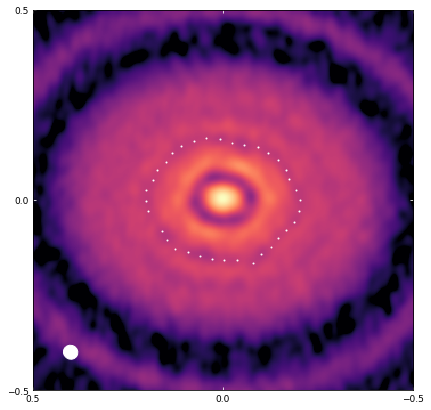

In [27]:
# Extract the gap that's at ~23 AU
xcoords7, ycoords7 = cont.extract_ring(20,26,tbins = -175+10*np.arange(36), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords7, ycoords7, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_7 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     23/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords7, ycoords7)

In [28]:
sampler7 = run_mcmc(nwalkers, nthreads, nsteps, mle_7, lnprob, xcoords7, ycoords7)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

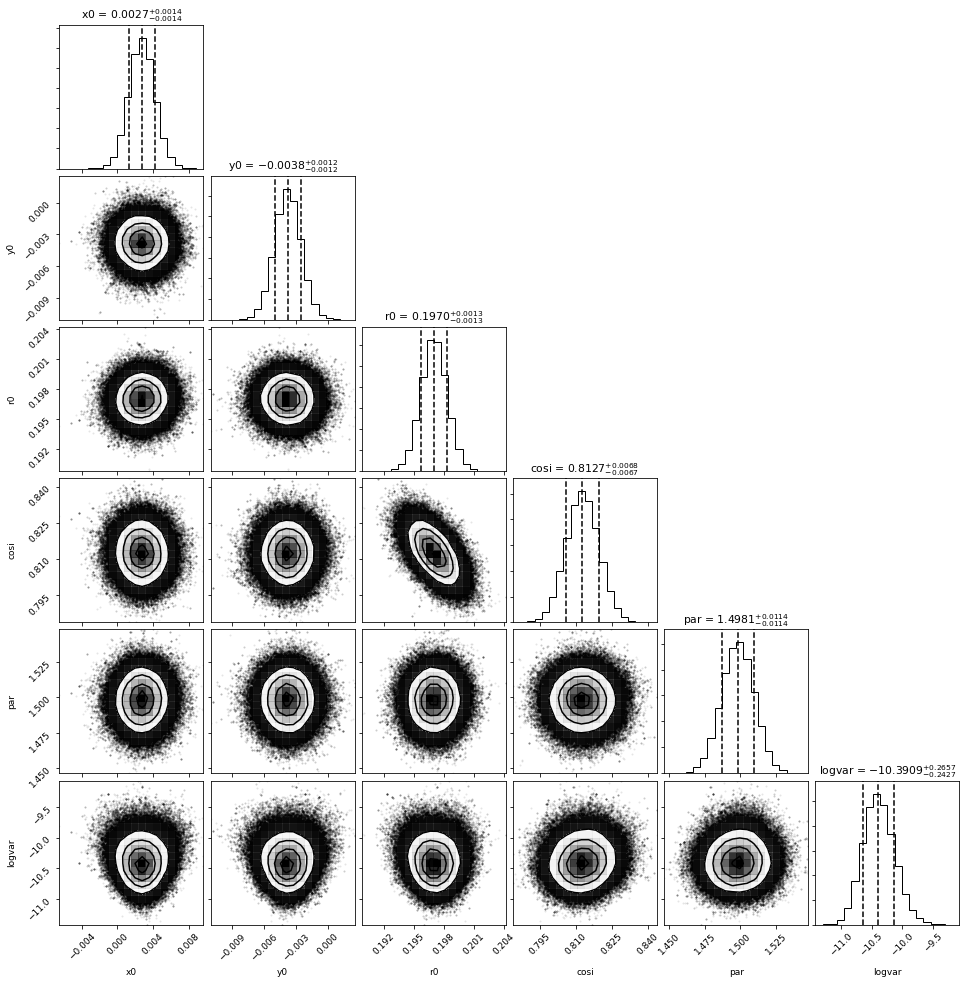

The x offset is delta_x = 2.74e-03 arcsec (+1.4e-03, -1.4e-03)
The y offset is delta_y = -3.78e-03 arcsec (+1.2e-03, -1.2e-03)
The median semi-major axis is r = 0.1970 arcsec (+0.0013, -0.0013) 
or 23.84 AU (+0.15, -0.15)
The incl is i = 35.64 deg (+0.65, -0.67)
The median position angle is PA = 85.83 deg (+0.65, -0.66)
The median log-variance in the pixel offsets from the true ellipse is -1.039e+01


In [29]:
plot_corner(sampler7, 500, 1)
sampler_results(sampler7, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.985e-03 arcsec, delta_y = -4.232e-03 arcsec
The MLE semi-major axis is r = 0.116 arcsec
The MLE inclination is i = 32.455 degrees
The MLE position angle is PA = 83.165 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.147e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


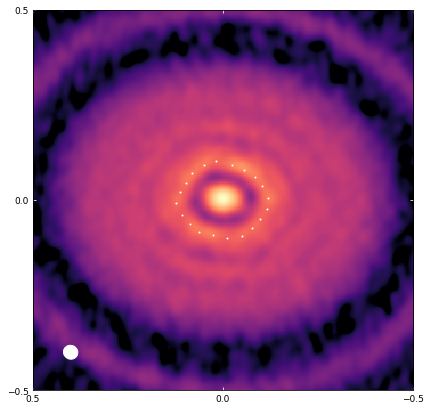

In [30]:
# Extract the ring that's at ~14 AU
xcoords8, ycoords8 = cont.extract_ring(10,20,tbins = -171+18*np.arange(20), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords8, ycoords8, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_8 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     14/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords8, ycoords8)

In [31]:
sampler8 = run_mcmc(nwalkers, nthreads, nsteps, mle_8, lnprob, xcoords8, ycoords8)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

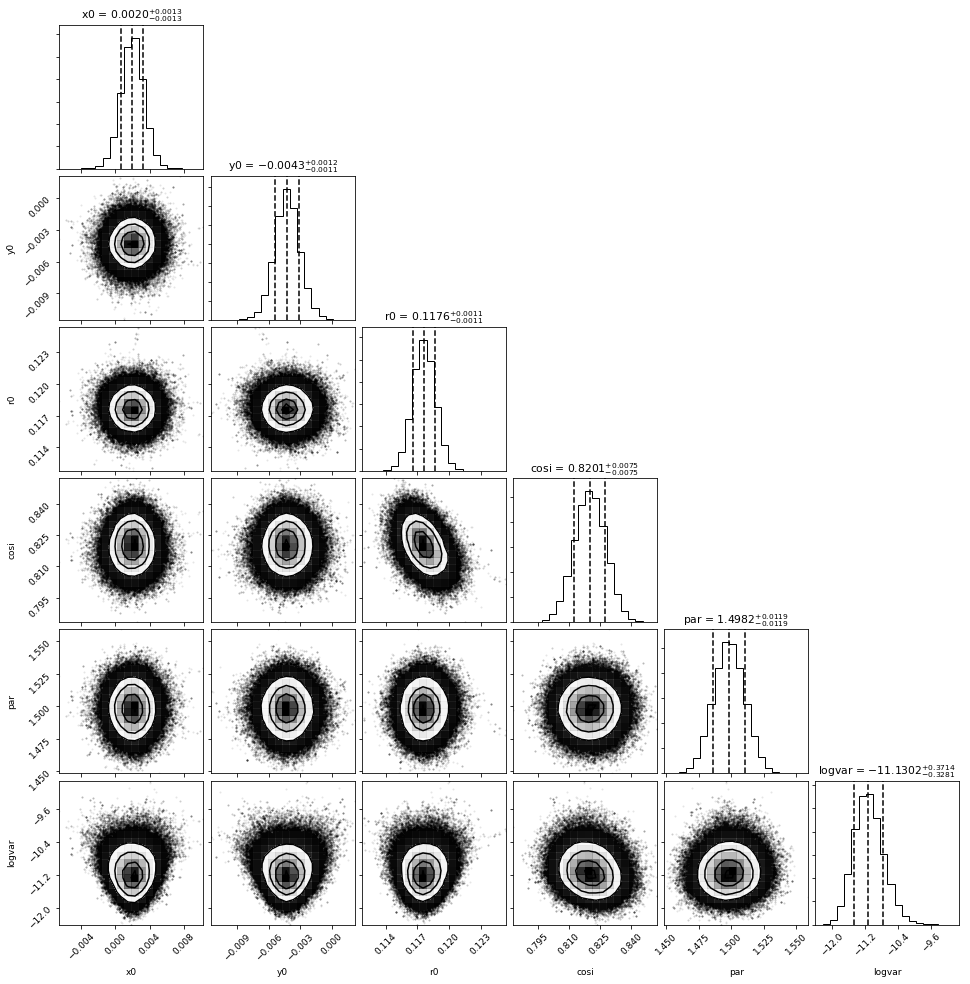

The x offset is delta_x = 1.98e-03 arcsec (+1.3e-03, -1.3e-03)
The y offset is delta_y = -4.27e-03 arcsec (+1.2e-03, -1.1e-03)
The median semi-major axis is r = 0.1176 arcsec (+0.0011, -0.0011) 
or 14.23 AU (+0.14, -0.14)
The incl is i = 34.91 deg (+0.74, -0.76)
The median position angle is PA = 85.84 deg (+0.68, -0.68)
The median log-variance in the pixel offsets from the true ellipse is -1.113e+01


In [32]:
plot_corner(sampler8, 500, 1)
sampler_results(sampler8, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.304e-03 arcsec, delta_y = -3.528e-03 arcsec
The MLE semi-major axis is r = 0.794 arcsec
The MLE inclination is i = 33.176 degrees
The MLE position angle is PA = 87.813 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -7.232e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


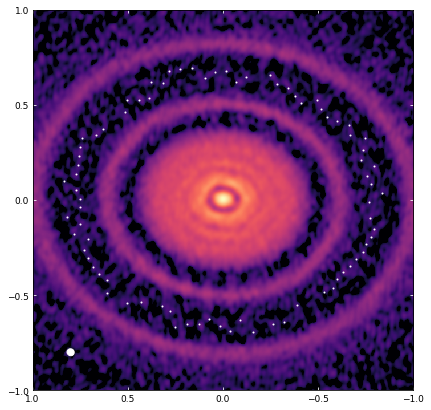

In [55]:
# Extract the ring that's at ~100 AU
xcoords9, ycoords9 = cont.extract_ring(90,105,tbins = -178+4*np.arange(90), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords9, ycoords9, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_9 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     100/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords9, ycoords9)

In [56]:
sampler9 = run_mcmc(nwalkers, nthreads, nsteps, mle_9, lnprob, xcoords9, ycoords9)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

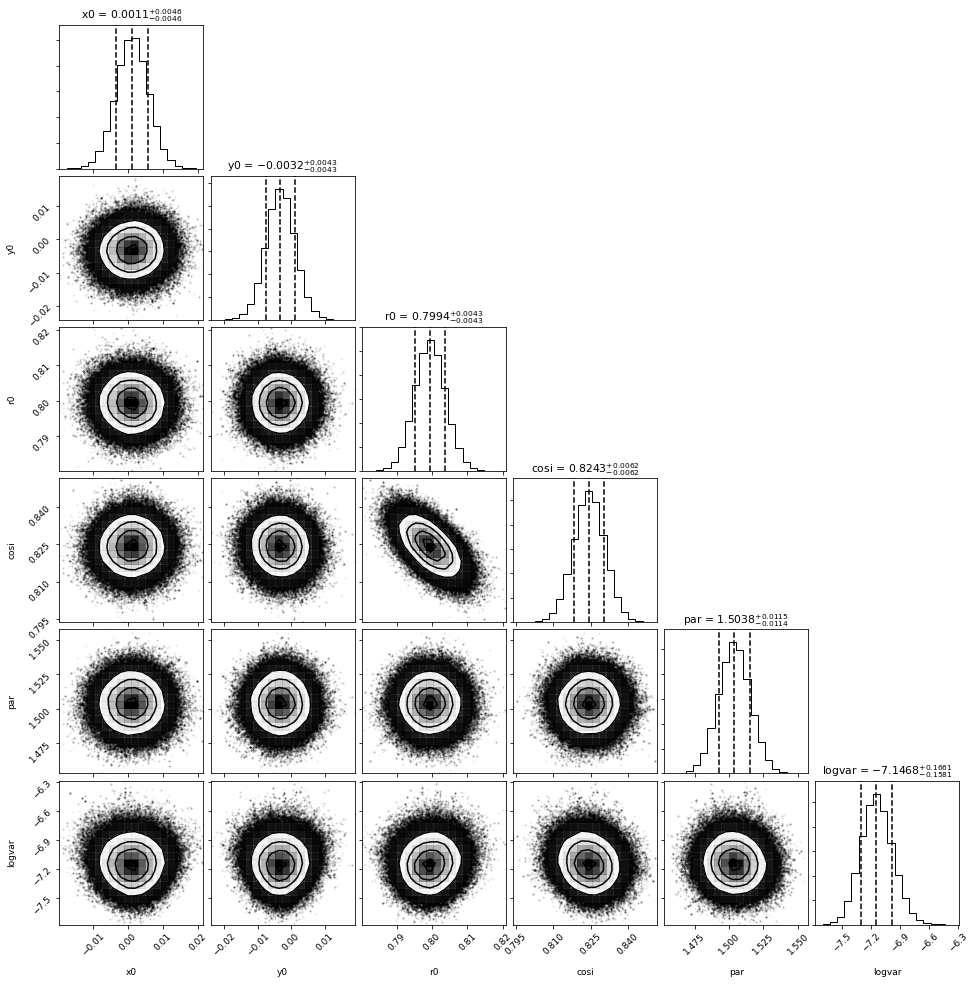

The x offset is delta_x = 1.14e-03 arcsec (+4.6e-03, -4.6e-03)
The y offset is delta_y = -3.22e-03 arcsec (+4.3e-03, -4.3e-03)
The median semi-major axis is r = 0.7994 arcsec (+0.0043, -0.0043) 
or 96.73 AU (+0.52, -0.52)
The incl is i = 34.48 deg (+0.63, -0.63)
The median position angle is PA = 86.16 deg (+0.66, -0.65)
The median log-variance in the pixel offsets from the true ellipse is -7.147e+00


In [57]:
plot_corner(sampler9, 500, 1)
sampler_results(sampler9, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 4.871e-04 arcsec, delta_y = 1.929e-04 arcsec
The MLE semi-major axis is r = 0.871 arcsec
The MLE inclination is i = 34.759 degrees
The MLE position angle is PA = 84.871 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.062e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


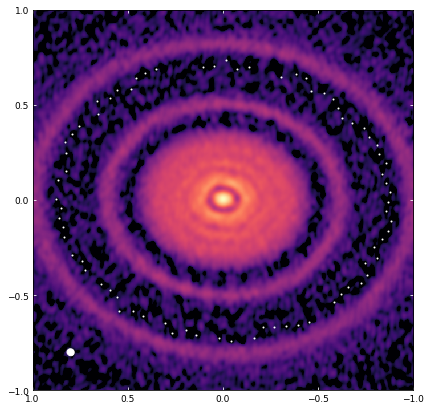

In [60]:
# Extract the gap that's at ~105 AU
xcoords10, ycoords10 = cont.extract_ring(100,110,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords10, ycoords10, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_10 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     105/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords10, ycoords10)

In [37]:
sampler10 = run_mcmc(nwalkers, nthreads, nsteps, mle_10, lnprob, xcoords10, ycoords10)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

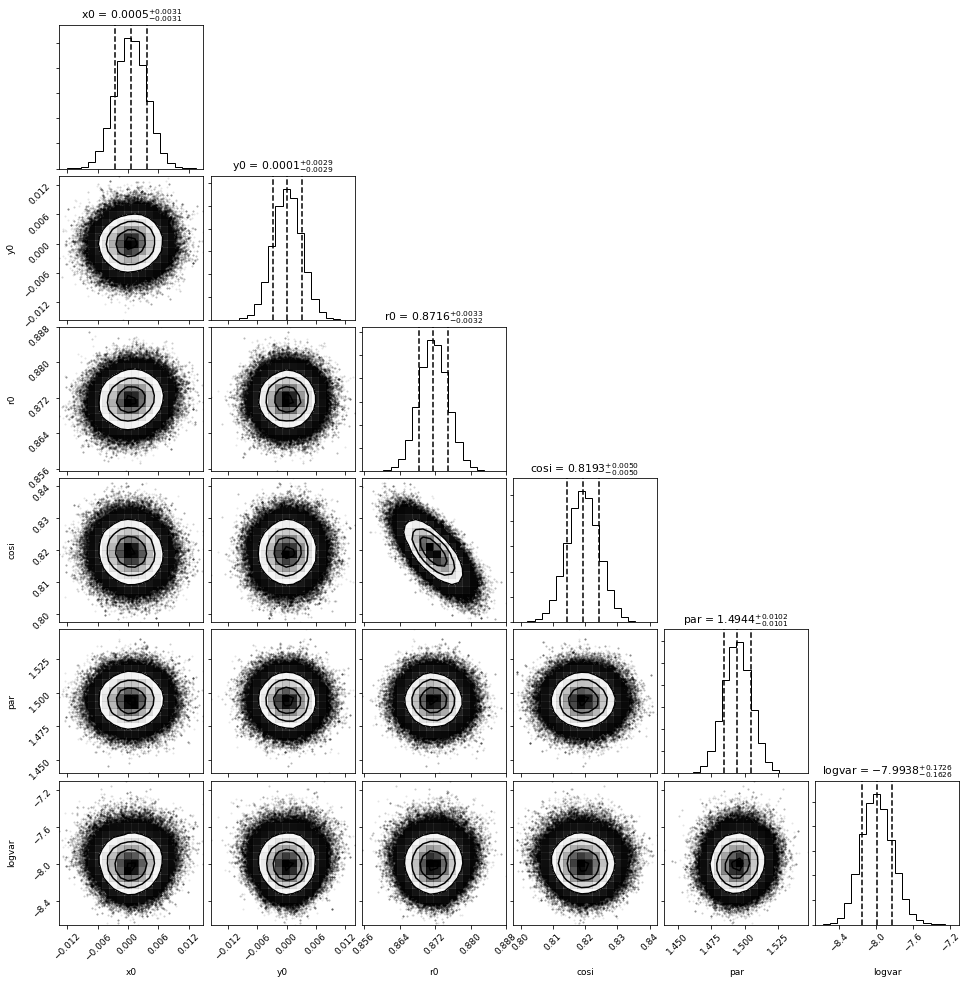

The x offset is delta_x = 5.35e-04 arcsec (+3.1e-03, -3.1e-03)
The y offset is delta_y = 1.29e-04 arcsec (+2.9e-03, -2.9e-03)
The median semi-major axis is r = 0.8716 arcsec (+0.0033, -0.0032) 
or 105.47 AU (+0.35, -0.35)
The incl is i = 34.98 deg (+0.49, -0.50)
The median position angle is PA = 85.62 deg (+0.59, -0.58)
The median log-variance in the pixel offsets from the true ellipse is -7.994e+00


In [38]:
plot_corner(sampler10, 500, 1)
sampler_results(sampler10, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.401e-03 arcsec, delta_y = -2.810e-03 arcsec
The MLE semi-major axis is r = 0.740 arcsec
The MLE inclination is i = 33.647 degrees
The MLE position angle is PA = 86.022 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.223e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


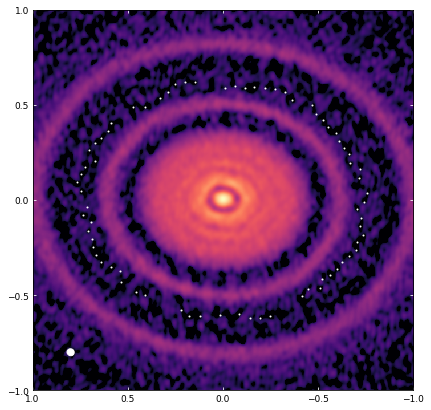

In [39]:
# Extract the gap that's at ~90 AU
xcoords11, ycoords11 = cont.extract_ring(85,95,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords11, ycoords11, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_11 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     95/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords11, ycoords11)

In [40]:
sampler11 = run_mcmc(nwalkers, nthreads, nsteps, mle_11, lnprob, xcoords11, ycoords11)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

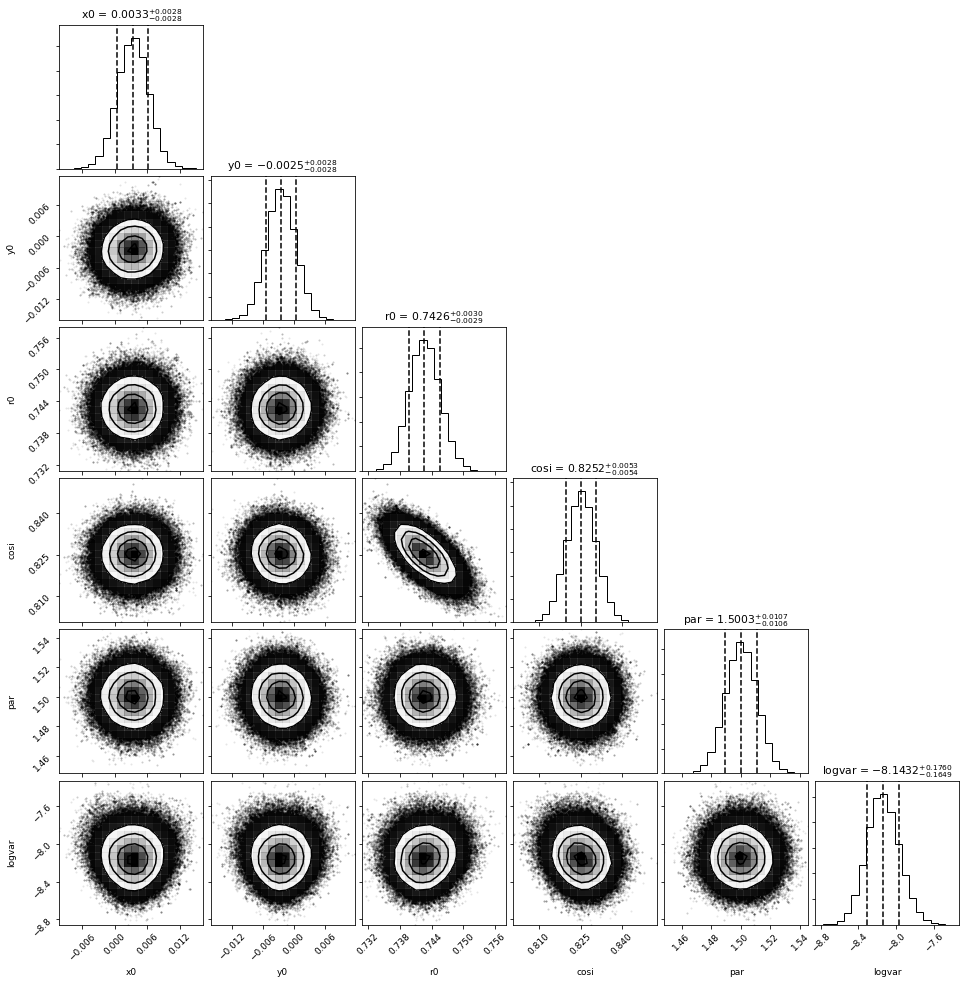

The x offset is delta_x = 3.32e-03 arcsec (+2.8e-03, -2.8e-03)
The y offset is delta_y = -2.52e-03 arcsec (+2.8e-03, -2.8e-03)
The median semi-major axis is r = 0.7426 arcsec (+0.0030, -0.0029) 
or 89.86 AU (+0.34, -0.34)
The incl is i = 34.39 deg (+0.54, -0.54)
The median position angle is PA = 85.96 deg (+0.61, -0.61)
The median log-variance in the pixel offsets from the true ellipse is -8.143e+00


In [41]:
plot_corner(sampler11, 500, 1)
sampler_results(sampler11, 500, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.085e-03 arcsec, delta_y = -3.941e-03 arcsec
The MLE semi-major axis is r = 0.073 arcsec
The MLE inclination is i = 38.341 degrees
The MLE position angle is PA = 78.422 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.480e+01


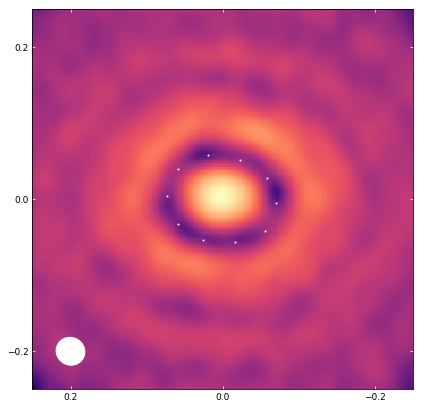

In [42]:
# Extract the gap that's at ~10 AU
xcoords12, ycoords12 = cont.extract_ring(5,15,tbins = -162+36*np.arange(10), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords12, ycoords12, 0.4, 0.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_12 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     10/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords12, ycoords12)

In [43]:
sampler12 = run_mcmc(nwalkers, nthreads, nsteps, mle_12, lnprob, xcoords12, ycoords12)


/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [61]:
np.savez("AS209ellipsechains.npz", BR120 = sampler1.chain, BR74 = sampler2.chain, DA61 = sampler3.chain, 
         BR39 = sampler4.chain, DA35 = sampler5.chain, BR28 = sampler6.chain, DA24 = sampler7.chain, 
        BR14 = sampler8.chain, BR97 = sampler9.chain, DA105 = sampler10.chain, DA90=sampler11.chain, DA9 = sampler12.chain)

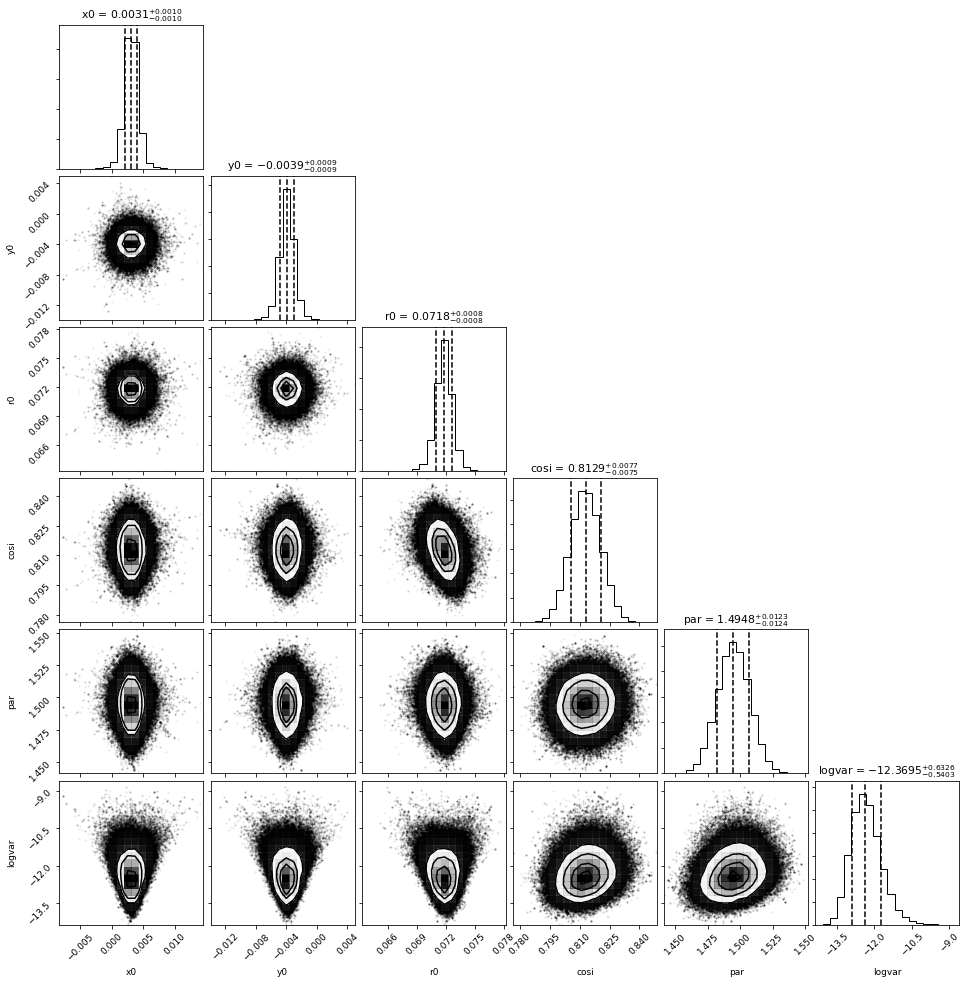

The x offset is delta_x = 3.09e-03 arcsec (+9.8e-04, -1.0e-03)
The y offset is delta_y = -3.92e-03 arcsec (+8.8e-04, -8.8e-04)
The median semi-major axis is r = 0.0718 arcsec (+0.0008, -0.0008) 
or 8.69 AU (+0.11, -0.11)
The incl is i = 35.62 deg (+0.73, -0.77)
The median position angle is PA = 85.65 deg (+0.71, -0.71)
The median log-variance in the pixel offsets from the true ellipse is -1.237e+01


In [44]:
plot_corner(sampler12, 500, 1)
sampler_results(sampler12, 500, cont.src_distance)

In [72]:

maxrad = 150
radialbins = 0.5+np.arange(0, maxrad)

newcont = Continuum(disk['filename'], 1.99e-3,-2.53e-3, 85.76, 34.97,disk['distance'])

newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))





max [14, 27, 38, 74, 95, 120, 141]
min [8, 23, 35, 60, 90, 106, 138]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


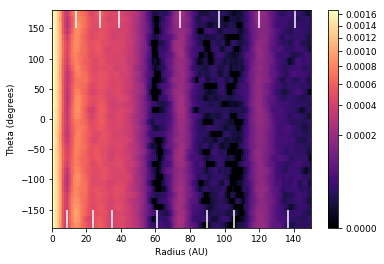

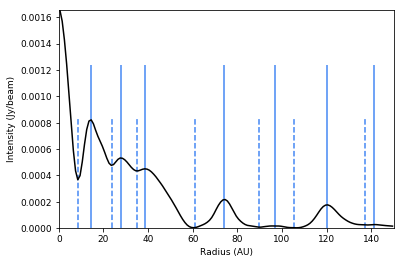

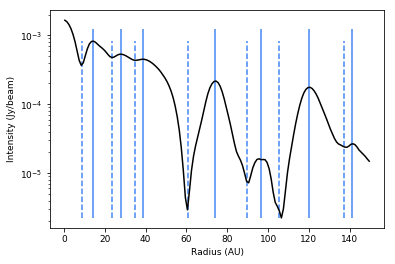

(0, 150)

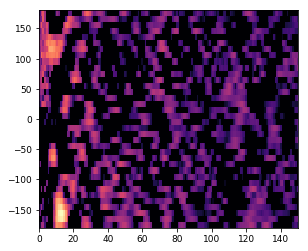

In [73]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
gaps = [8.7, 23.8, 35.0, 60.8, 89.9, 105.47,137]
rings = [14.2, 27.8,38.7, 74.2, 96.7, 120.1,141]
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = 150)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)

In [46]:
print(np.arange(0.5, 5, 0.1))
print(np.arange(0.5,5,1))

[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4
  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9]
[ 0.5  1.5  2.5  3.5  4.5]


In [74]:
calc_contrast(8.69, 14.2, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.4465314083783592, 0.019947372495706148)

In [93]:
measure_widths(8.69, 14.2, radialbins, newsurfbrightness, 0, 24)

0.000595829357416 11.2


(4.6999999999999993, 8.8999999999999968)

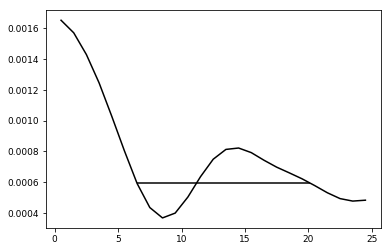

In [96]:
plt.plot(radialbins[:25], newsurfbrightness[:25], color = 'black')
plt.hlines(0.000595829357416, 11.2-4.7, 11.2)
plt.hlines(0.000595829357416, 11.2, 11.2+8.9)

In [97]:
calc_contrast(23.84, 27.8, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.89524976703238757, 0.013260032642237617)

In [99]:
measure_widths(23.84, 27.8, radialbins, newsurfbrightness, 14, 35)

0.000504645609246 25.6


(3.3999999999999986, 4.6999999999999993)

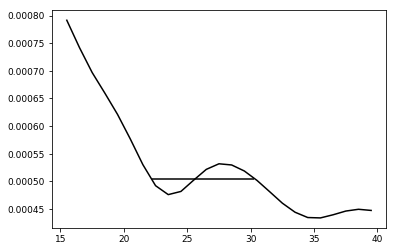

In [101]:
plt.plot(radialbins[15:40], newsurfbrightness[15:40], color = 'black')
plt.hlines(0.000504645609246, 25.6-3.4, 25.6)
plt.hlines(0.000504645609246, 25.6, 25.6+4.7)

In [102]:
calc_contrast(35.04, 38.7, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.96528822695475791, 0.010011818770342171)

In [103]:
measure_widths(35.04, 38.7, radialbins, newsurfbrightness, 32, 45)

0.000441886325014 36.8


(3.0, 3.3999999999999986)

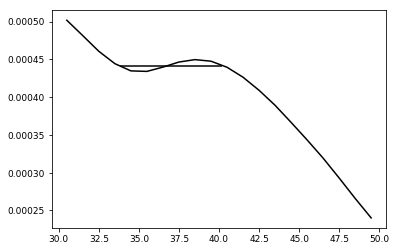

In [106]:
plt.plot(radialbins[30:50], newsurfbrightness[30:50], color = 'black')
plt.hlines(0.000441886325014, 36.8-3, 36.8)
plt.hlines(0.000441886325014, 36.8, 36.8+3.4)

In [107]:
calc_contrast(60.8, 74.15, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.013558859479684254, 0.011494554958664275)

In [108]:
measure_widths(60.8, 74.15, radialbins, newsurfbrightness, 40, 90)

0.000109789993702 69.5


(15.5, 9.2999999999999972)

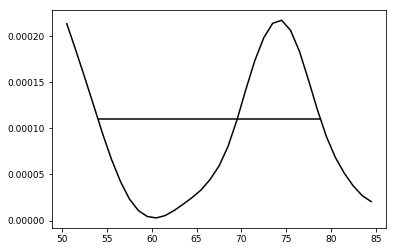

In [110]:
plt.plot(radialbins[50:85], newsurfbrightness[50:85], color = 'black')
plt.hlines(0.000109789993702, 69.5-15.5, 69.5)
plt.hlines(0.000109789993702, 69.5, 69.5+9.3)

In [111]:
calc_contrast(89.9,96.7, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.48196409954695923, 0.1274176873507431)

In [112]:
measure_widths(89.9,96.7, radialbins, newsurfbrightness, 74, 105)

1.15896433981e-05 92.4


(4.5, 8.0999999999999943)

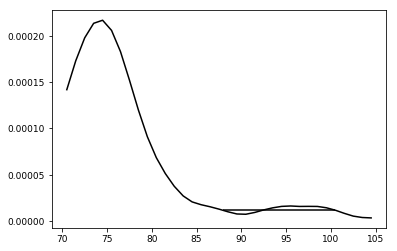

In [115]:
plt.plot(radialbins[70:105], newsurfbrightness[70:105], color = 'black')
plt.hlines(1.15896433981e-05, 92.4-4.5, 92.4)
plt.hlines(1.15896433981e-05, 92.4, 92.4+8.1)

In [121]:
measure_widths(105.2, 120.3, radialbins, newsurfbrightness, 100, 137)

8.93847833648e-05 115.2


(14.700000000000003, 11.200000000000003)

In [122]:
calc_contrast(105.2, 120.3, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.016056632788702514, 0.0094781155713877484)

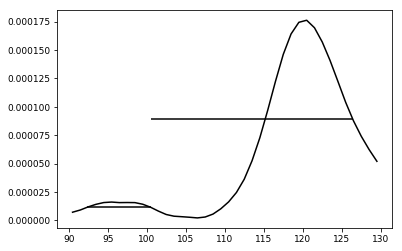

In [131]:
plt.plot(radialbins[90:130], newsurfbrightness[90:130], color = 'black')
plt.hlines(1.15896433981e-05, 92.4, 92.4+8.1)
plt.hlines(8.93847833648e-05, 115.2-14.7, 115.2)
plt.hlines(8.93847833648e-05, 115.2, 115.2+11.2)


In [116]:
calc_contrast(137.001, 141.001, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.89624864967808682, 0.068979906709635788)

In [117]:
measure_widths(137.001, 141.001, radialbins, newsurfbrightness, 130, 150)

2.5379004498e-05 140.0


(4.1999999999999886, 2.7999999999999829)

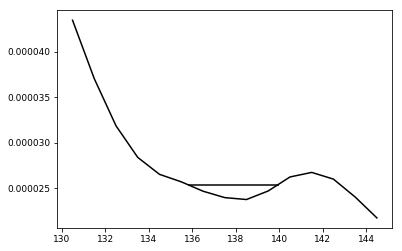

In [120]:
plt.plot(radialbins[130:145], newsurfbrightness[130:145], color = 'black')
plt.hlines(2.5379004498e-05, 140-4.2, 140)
#plt.hlines(2.5379004498e-05, 140, 140+2.8)

In [ ]:
Imean = 0.5*(newsurfbrightness[98]+newsurfbrightness[89])
print(Imean)
np.argmin(np.abs(Imean - newsurfbrightness[98:]))+98

138.5
138.5


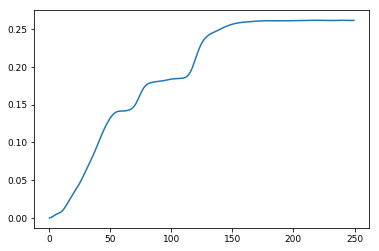

In [155]:
bins = 0.5+1*np.arange(0, 250)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])
print(bins[np.argmin(np.abs(cumeflux-0.9492*np.max(cumeflux)))])

In [141]:
area = np.pi*np.cos(35*np.pi/180.)*(138.5/121)**2
beamsize = np.pi*newcont.bmin*newcont.bmaj/(4*np.log(2))

In [142]:
area/beamsize

2149.4271896362834

In [145]:
np.sqrt(area/(.003**2))*1.5e-5/np.sqrt(area/beamsize)

0.00019802965658748472

In [148]:
.000198/cumeflux[138]*100

0.079678860764324316

In [182]:
def randfluxprofile(cont, radialbins):

    rbins = radialbins
    rwidth = (rbins[1]-rbins[0])

    flux_bin = np.zeros(len(rbins))
 
    for i in range(len(rbins)):
        annulus_intensities = cont.image[(cont.r>=(rbins[i]-0.5*rwidth)) & (cont.r<(rbins[i]+0.5*rwidth))]
        
        flux_bin[i] = np.sum(np.random.choice(annulus_intensities, size = len(annulus_intensities),replace = True))

    beamsize = np.pi*cont.bmin*cont.bmaj/(4*np.log(2))
        
    return np.cumsum(flux_bin)*(cont.delt_y)**2/beamsize

In [183]:
randprof = randfluxprofile(newcont, bins)

In [184]:
print(bins[np.argmin(np.abs(randprof-0.95*np.max(randprof)))])

138.5


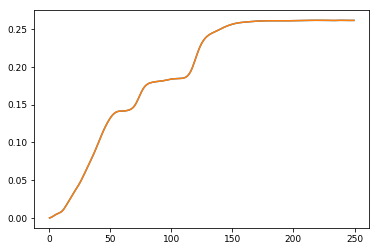

In [185]:
plt.plot(bins, cumeflux)
plt.plot(bins, randprof)

In [188]:
newSB_scatter/10

array([  2.13260277e-06,   4.42730978e-06,   5.86084963e-06,
         6.80010652e-06,   7.05609608e-06,   7.50281246e-06,
         6.73964661e-06,   5.70024499e-06,   4.93987844e-06,
         5.79460615e-06,   7.38464710e-06,   8.08725252e-06,
         7.77010954e-06,   7.01977283e-06,   6.07476803e-06,
         5.30094553e-06,   4.19863409e-06,   3.18839858e-06,
         3.13916037e-06,   3.76071728e-06,   4.02711206e-06,
         3.86282718e-06,   3.34069518e-06,   2.90039631e-06,
         3.05897460e-06,   3.20712480e-06,   3.15029139e-06,
         3.02437199e-06,   2.85311344e-06,   2.70752535e-06,
         2.55239391e-06,   2.45465696e-06,   2.37671983e-06,
         2.25555177e-06,   2.06043722e-06,   2.01542279e-06,
         2.25146995e-06,   2.41572695e-06,   2.37050152e-06,
         2.31455896e-06,   2.26616407e-06,   2.17405697e-06,
         2.23951665e-06,   2.38301766e-06,   2.44732599e-06,
         2.35102445e-06,   2.27759647e-06,   2.27678382e-06,
         2.36457979e-06,